In [1]:
import os
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.mixed_precision import set_global_policy

2025-01-02 03:18:24.388538: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-02 03:18:24.408407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735805904.433900  131778 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735805904.442356  131778 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-02 03:18:24.467928: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import tensorflow as tf
import keras

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)


TensorFlow version: 2.18.0
Keras version: 3.7.0


In [3]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf


In [4]:
import sys
# Add the scripts folder to the system path
scripts_path = os.path.abspath(os.path.join('..', 'scripts/python'))
sys.path.append(scripts_path)


In [5]:
# Import necessary libraries
import os
import sys
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, TFAutoModel, AutoModelForCausalLM, pipeline
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.mixed_precision import set_global_policy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Adjust system path to include 'utils.py'
scripts_path = os.path.abspath(os.path.join('..', 'scripts/python'))
sys.path.append(scripts_path)

# Import utility functions
from utils import (
    create_thepoet_pipeline,
    create_aragpt2_for_classical_style,
    train_aragpt2_for_classical_style,
    #create_diffusion_model,
    string_with_tashkeel_vectorizer,
    generate_classical_poem_with_thepoet,
    create_thepoet_pipeline
)

# Configure TensorFlow and Mixed Precision (if needed)
# Uncomment the following lines if you wish to enable mixed precision
# set_global_policy('mixed_float16')

# Configure visualization settings
%matplotlib inline

In [6]:
# --------------------------
# Section 1: Setup and Data Loading
# --------------------------

# Define paths
processed_data_path = '../data/processed/processed_taweel_data.csv'
diffusion_output_dir = '../models/diffusion'
transformer_output_dir = '../models/transformers'

# Create necessary directories
os.makedirs(diffusion_output_dir, exist_ok=True)
os.makedirs(transformer_output_dir, exist_ok=True)

# Load processed data
print("Loading processed data...")
try:
    processed_df = pd.read_csv(processed_data_path, encoding='utf-8-sig')
    print(f"Processed data loaded with {len(processed_df)} records.")
except FileNotFoundError:
    print(f"File not found: {processed_data_path}. Please check the path and try again.")
    sys.exit(1)

# Optional: subset for quick tests
subset = True
if subset:
    print("Using subset for testing...")
    train_df, valid_df = train_test_split(processed_df, test_size=0.2, random_state=42)
    train_subset = train_df.sample(n=100, random_state=42)
    valid_subset = valid_df.sample(n=20, random_state=42)
else:
    train_df, valid_df = train_test_split(processed_df, test_size=0.2, random_state=42)
    train_subset, valid_subset = train_df, valid_df

print(f"Training records: {len(train_subset)}; Validation records: {len(valid_subset)}")

Loading processed data...
Processed data loaded with 103441 records.
Using subset for testing...
Training records: 100; Validation records: 20


In [7]:
# --------------------------
# 1) Load ThePoet Pipeline
# --------------------------
print("Creating ThePoet pipeline...")
poet_pipeline = create_thepoet_pipeline()
print("ThePoet pipeline created.")

Creating ThePoet pipeline...


Device set to use cuda:0


ThePoet pipeline created.


In [8]:
# --------------------------
# Section 3: Transformer Model Training
# --------------------------
import pandas as pd
from transformers import AutoTokenizer
import tensorflow as tf
import numpy as np

print("Training Transformer (AraGPT2) in auto-encoder style for classical poems...")

# Define model and tokenizer
transformer_name = "aubmindlab/aragpt2-base"  # AraGPT2 model
transformer_tokenizer = AutoTokenizer.from_pretrained(transformer_name)
transformer_tokenizer.pad_token = transformer_tokenizer.eos_token

# Create the model without passing the tokenizer
transformer_model = create_aragpt2_for_classical_style(
    model_name=transformer_name,
    max_length=128,  # Consistent with max_bayt_len
    freeze_layers=0   # Adjust if you want to freeze lower layers
)

# **Set the model's pad_token_id to match the tokenizer's pad_token_id**
transformer_model.config.pad_token_id = transformer_tokenizer.pad_token_id
print(f"Model's pad_token_id set to: {transformer_model.config.pad_token_id}")

# Define output directory
transformer_output_dir = './transformer_output'

# Assume `train_subset` is your training DataFrame
# Example:
# train_subset = pd.DataFrame({'text': ['Your classical poem line 1', 'Your classical poem line 2', ...]})

# **Verify the Tokenizer and Model Configuration**
print(f"Tokenizer's pad token: {transformer_tokenizer.pad_token}")
print(f"Tokenizer's pad token ID: {transformer_tokenizer.pad_token_id}")
print(f"Model's pad_token_id: {transformer_model.config.pad_token_id}")

# Fine-tuning AraGPT2
trained_transformer, hist = train_aragpt2_for_classical_style(
    df_classical=train_subset,
    tokenizer=transformer_tokenizer,
    model=transformer_model,
    max_length=128,  # Consistent with max_bayt_len
    epochs=3, 
    batch_size=2, 
    output_dir=transformer_output_dir
)

print("Transformer (AraGPT2) training complete.")

Training Transformer (AraGPT2) in auto-encoder style for classical poems...


I0000 00:00:1735805915.496072  131778 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2376 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2LMHeadModel: ['h.10.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.11.attn.masked_bias', 'h.0.attn.masked_bias', 'h.5.attn.masked_bias', 'h.3.attn.masked_bias', 'h.8.attn.masked_bias', 'h.2.attn.masked_bias', 'h.4.attn.masked_bias', 'h.9.attn.masked_bias', 'h.1.attn.masked_bias']
- This IS expected if you are initializing TFGPT2LMHeadModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2LMHeadModel from a PyTorch model that you expect to be exactly identical (e.g. i

Model's pad_token_id set to: 0
Tokenizer's pad token: <|endoftext|>
Tokenizer's pad token ID: 0
Model's pad_token_id: 0


AttributeError: 'EarlyStopping' object has no attribute '_implements_train_batch_hooks'

In [11]:
import tensorflow as tf
import transformers
print(tf.__version__)
print(transformers.__version__)


2.17.0
4.47.1


In [11]:
# --------------------------
# Section 4: Save the Transformer Model and Tokenizer
# --------------------------

# Save the final Transformer model using Hugging Face's save_pretrained
print("Saving the Transformer model and tokenizer using save_pretrained...")
trained_transformer.save_pretrained(transformer_output_dir)
print(f"Transformer model saved to {transformer_output_dir}")

# Save the tokenizer correctly
transformer_tokenizer.save_pretrained(transformer_output_dir)
print(f"Tokenizer saved to {transformer_output_dir}")

Saving the Transformer model and tokenizer using save_pretrained...
Transformer model saved to ../models/transformers
Tokenizer saved to ../models/transformers


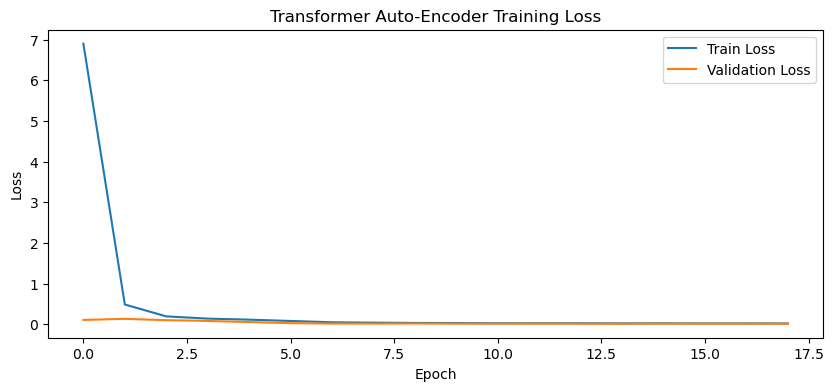

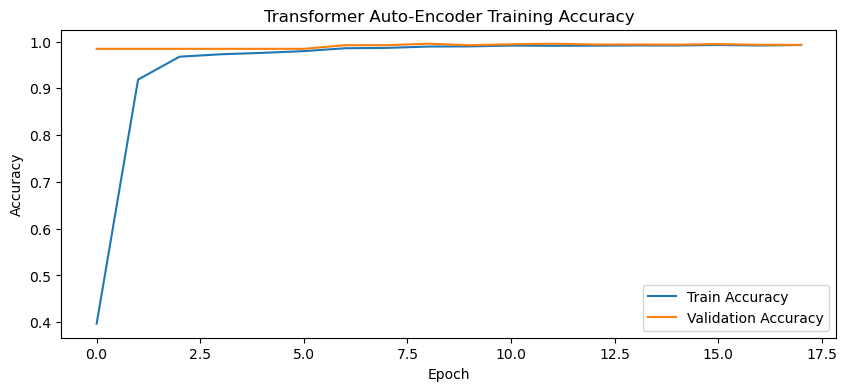

In [10]:
# --------------------------
# Section 5: Plot Transformer Training History
# --------------------------

# Plot training history (optional)
plt.figure(figsize=(10, 4))
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title("Transformer Auto-Encoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title("Transformer Auto-Encoder Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [ ]:
# --------------------------
# Section 6: Diffusion Model Training
# --------------------------
# Ensure max_bayt_len is consistent with max_length=128
max_bayt_len = 128  # Changed from 1000 to 128
encoding_dim = 8
input_shape = (max_bayt_len, encoding_dim)
diffusion_model_params = {
    'num_transformer_blocks': 4,
    'num_heads': 8,
    'key_dim': 64,
    'ffn_units': 512
}
print("Creating diffusion model...")
diffusion_model = create_diffusion_model(input_shape, diffusion_model_params)
print("Diffusion model created.")

# Vectorize training and validation data
print("Vectorizing training and validation data...")

def string_with_tashkeel_vectorizer_per_batch(batch_series, max_bayt_len):
    out = []
    for val in batch_series:
        vector = string_with_tashkeel_vectorizer(val, max_bayt_len)
        out.append(vector)
    return np.stack(out, axis=0)

X_train_enc = string_with_tashkeel_vectorizer_per_batch(pd.Series(train_subset['text']), max_bayt_len=128)
Y_train_enc = X_train_enc.copy()
X_valid_enc = string_with_tashkeel_vectorizer_per_batch(pd.Series(valid_subset['text']), max_bayt_len=128)
Y_valid_enc = X_valid_enc.copy()

batch_size = 8
epochs = 5
print("Training diffusion model (example)...")
ckpt_path = os.path.join(diffusion_output_dir, "diff_ckpt")
ckpt = ModelCheckpoint(ckpt_path, save_best_only=True,
                       monitor='val_mae', mode='min', verbose=1)
es = EarlyStopping(monitor='val_mae', patience=2, restore_best_weights=True, mode='min')
tb = TensorBoard(log_dir=os.path.join(diffusion_output_dir, 'logs'))

diffusion_history = diffusion_model.fit(
    X_train_enc, Y_train_enc,
    validation_data=(X_valid_enc, Y_valid_enc),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[ckpt, es, tb]
)
print("Diffusion training complete.")

# Save the final Diffusion model
final_diffusion_path = os.path.join(diffusion_output_dir, "diffusion_model_final.h5")
diffusion_model.save(final_diffusion_path, include_optimizer=True)
print(f"Final Diffusion model saved to {final_diffusion_path}")


In [ ]:
# --------------------------
# Section 7: Plot Diffusion Model Training History
# --------------------------

# Plot diffusion training
plt.figure(figsize=(10, 4))
plt.plot(diffusion_history.history['loss'], label='Train Loss')
plt.plot(diffusion_history.history['val_loss'], label='Val Loss')
plt.title("Diffusion Model Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(diffusion_history.history['mae'], label='Train MAE')
plt.plot(diffusion_history.history['val_mae'], label='Val MAE')
plt.title("Diffusion Model MAE")
plt.legend()
plt.show()

In [12]:
# --------------------------
# Section 8: Generate Final Poem via ThePoet -> Transformer -> Diffusion
# --------------------------
modern_prompt = "يا جمال الزمان ويا نور الأمل"

print("Generating final classical poem by chaining ThePoet -> Transformer -> Diffusion...")
try:
    final_poem = generate_classical_poem_with_thepoet(
        modern_prompt=modern_prompt,
        poet_pipeline=poet_pipeline,
        transformer_model=trained_transformer,
        transformer_tokenizer=transformer_tokenizer,
        #diffusion_model=diffusion_model,
        max_length=128
    )
    print("\n==== Final Chained Poem ====")
    print(final_poem)
    print("================================")
except ValueError as ve:
    print(f"Error during poem generation: {ve}")
except Exception as e:
    print(f"Unexpected error during poem generation: {e}")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Generating final classical poem by chaining ThePoet -> Transformer -> Diffusion...
Generated rough poems from ThePoet:
1: يا جمال الزمان ويا نور الأمل. فلا زلت يا بدر الدجى - في كل يوم تشرق شمسا. ولقد كان لي من حسنها - ما لم يكن عندي لها ندا. كأنني قد كنت أهيم بها -

Rough Poem from ThePoet: يا جمال الزمان ويا نور الأمل. فلا زلت يا بدر الدجى - في كل يوم تشرق شمسا. ولقد كان لي من حسنها - ما لم يكن عندي لها ندا. كأنني قد كنت أهيم بها -

Rough Poem after replacing hyphens with spaces: يا جمال الزمان ويا نور الأمل. فلا زلت يا بدر الدجى في كل يوم تشرق شمسا. ولقد كان لي من حسنها ما لم يكن عندي لها ندا. كأنني قد كنت أهيم بها

Number of verses extracted: 4
Verse 1: يا جمال الزمان ويا نور الأمل
Verse 2: فلا زلت يا بدر الدجى في كل يوم تشرق شمسا
Verse 3: ولقد كان لي من حسنها ما لم يكن عندي لها ندا
Verse 4: كأنني قد كنت أهيم بها

Processing Verse 1: يا جمال الزمان ويا نور الأمل
Verse split into halves: يا جمال الزمان   ويا نور الأمل


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Diacritized Verse: يا جَمالُ الزَّمانِ وَيا نورَ الأَمَلِ
Diacritized Verse re-split into halves: يا جَمالُ الزَّمانِ   وَيا نورَ الأَمَلِ
Classical Draft from Transformer:    
Final Verse after Transformer Refinement:    

Processing Verse 2: فلا زلت يا بدر الدجى في كل يوم تشرق شمسا
Verse split into halves: فلا زلت يا بدر الدجى   في كل يوم تشرق شمسا


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Diacritized Verse: فَلا زَلّتْ يا بَدْرُ الدُّجَى في كُلِّ يَوْمٍ تُشْرِقَ شَمْسًا
Diacritized Verse re-split into halves: فَلا زَلّتْ يا بَدْرُ الدُّجَى   في كُلِّ يَوْمٍ تُشْرِقَ شَمْسًا
Classical Draft from Transformer:   
Final Verse after Transformer Refinement:   

Processing Verse 3: ولقد كان لي من حسنها ما لم يكن عندي لها ندا
Verse split into halves: ولقد كان لي من حسنها   ما لم يكن عندي لها ندا


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Diacritized Verse: وَلَقَدْ كانَ لي مِنْ حُسْنِها ما لَمْ يَكُنْ عِنْدي لَها نِدًّا
Diacritized Verse re-split into halves: وَلَقَدْ كانَ لي مِنْ حُسْنِها   ما لَمْ يَكُنْ عِنْدي لَها نِدًّا
Classical Draft from Transformer:   
Final Verse after Transformer Refinement:   

Processing Verse 4: كأنني قد كنت أهيم بها
Verse split into halves: كأنني قد   كنت أهيم بها


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Diacritized Verse: كَأَنَّني قَدْ كُنْتْ أهيمْ بِها
Diacritized Verse re-split into halves: كَأَنَّني قَدْ   كُنْتْ أهيمْ بِها
Classical Draft from Transformer:   
Final Verse after Transformer Refinement:   

==== Final Chained Poem ====
   
  
  
  

==== Final Chained Poem ====
   
  
  
  
